## Collision Insights

In [2]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, isnull, hour, dayofweek, date_format, when, lit

In [3]:
print("Initializing Spark Session...")
spark = SparkSession.builder \
    .appName("CollisionInsights") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
print("Spark Session initialized.")

csv_file_path = "/home/paul/projects/collision-insights/data/US_Accidents_March23.csv"

print(f"Loading data from {csv_file_path}...")
try:
    df = spark.read \
        .option("header", True) \
        .option("inferSchema", True) \
        .csv(csv_file_path)
    print("Data loaded successfully.")
    print(f"Number of partitions: {df.rdd.getNumPartitions()}")
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    exit()

Initializing Spark Session...


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/05 11:45:04 WARN Utils: Your hostname, paul-Alienware-Aurora-Ryzen-Edition, resolves to a loopback address: 127.0.1.1; using 192.168.1.8 instead (on interface wlp5s0)
25/06/05 11:45:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/05 11:45:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session initialized.
Loading data from /home/paul/projects/collision-insights/data/US_Accidents_March23.csv...


Data loaded successfully.
Number of partitions: 23


In [ ]:
# Basic Data Exploration

print("\n--- DataFrame Schema ---")
df.printSchema()

# print("\n--- First 5 Rows ---")
# df.show(5, truncate=False)

print("\n--- Total Number of Records ---")
num_records = df.count()
print(f"Total records: {num_records}")

#TODO fix - this is showing a bunch of columns that just incorrectly have numbers like description
print("\n--- Statistics for Numerical Columns ('Describe') ---")
# This can take some time for very large datasets
df.describe().show(truncate=False)

print("\n--- Check for Null Values (Top Columns with Nulls) ---")
# Calculate null counts for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Filter and show columns with any nulls
null_counts_df = null_counts.toPandas().transpose()
null_counts_df.columns = ['null_count']
null_columns_with_values = null_counts_df[null_counts_df['null_count'] > 0]

print(null_columns_with_values.sort_values(by='null_count', ascending=False))


--- DataFrame Schema ---
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doubl

Total records: 7728394

--- Statistics for Numerical Columns ('Describe') ---


+-------+--------+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+----------------------------------------------------------------------------------------+------------------+----------+---------+-------+------------------+-------+----------+------------+------------------+-----------------+------------------+------------------+-----------------+--------------+-----------------+--------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|ID      |Source |Severity          |Start_Lat        |Start_Lng         |End_Lat          |End_Lng           |Distance(mi)      |Description                                                                             |Street            |City      |County   |State  |Zipcode           |Country|Timezone  |Airport_Code|Temperature(F)    |Wind_Chill(F)    |Humidity(%)       |Pressure(in)      |Visibility(mi)   |Wind_Direction|Win

                       null_count
End_Lat                   3402762
End_Lng                   3402762
Precipitation(in)         2203586
Wind_Chill(F)             1999019
Wind_Speed(mph)            571233
Visibility(mi)             177098
Wind_Direction             175206
Humidity(%)                174144
Weather_Condition          173459
Temperature(F)             163853
Pressure(in)               140679
Weather_Timestamp          120228
Sunrise_Sunset              23246
Civil_Twilight              23246
Nautical_Twilight           23246
Astronomical_Twilight       23246
Airport_Code                22635
Street                      10869
Timezone                     7808
Zipcode                      1915
City                          253
Description                     5


In [30]:
# Field sorting - done in code for now but not USED in code yet

# Fields highly relevant for identifying patterns, trends, and factors contributing to accidents.
highly_relevant = [
    # Basic Info
    'ID',                    # Unique accident identifier.
    'Severity',              # Accident impact level, core target.
    'Start_Time',            # Accident start time, critical for temporal trends.
    'End_Time',              # Accident end time, useful for duration.
    # Weather
    'Temperature(F)',        # Direct weather factors
    'Humidity(%)',           
    'Pressure(in)',          
    'Visibility(mi)',        # Crucial
    'Precipitation(in)',     
    'Weather_Condition',     # Categorical weather summary (e.g., Rain, Snow, Clear, Fog). 145 cats in a bag
    # Road features
    'Junction',              # Presence of an intersection.
    'Crossing',              # Presence of a crossing (pedestrian, railway).
    'Traffic_Signal',        # Presence of a traffic light.
    'Stop',                  # Presence of a stop sign.
    'Bump',                  # Presence of a speed bump.
    'Traffic_Calming',       # General traffic calming measures.
    'Roundabout',            # Presence of a roundabout.
    'Give_Way',              # Presence of a 'yield' sign.
]

# Fields that might be relevant but require more careful consideration, aggregation,
# or complex analysis, or describe impact/extent rather than direct cause.
# Nearly all geographical/location based in some way
maybe_relevant = [
    'Start_Lat',             # Latitude of accident start, requires aggregation
    'Start_Lng',             # Longitude ""
    'End_Lat',               # Latitude of accident end point, high nulls, describes impact
    'End_Lng',               # Longitude ""
    'Distance(mi)',          # Length of affected road, describes impact/extent, not direct cause
    'Street',                # Street name
    'City',                  # Geographical grouping, requires aggregation
    'County',                # ""
    'State',                 
    'Zipcode',               
    'Number',                # Street number
    'Description',           # Requires NLP for structured insights.
    'Sunrise_Sunset',        # General day/night period (light conditions).
    'Civil_Twilight',        # Different measures of twilight
    'Nautical_Twilight',     
    'Astronomical_Twilight'
]

# Fields considered likely not relevant
not_relevant = [
    'Source',                # Data provider
    'Country',               # All data is US
    'Timezone',              # Times are local
    'Airport_Code',          # Nearest weather station, imputation is out of scope
    'Wind_Chill(F)',         # Redundant with Temp and Wind_Speed
    'Wind_Direction',        # Requires advanced analysis for accident correlation.
    'Amenity',               # "Is a bank nearby" very unlikely to be relevant
    'No_Exit',               # Same
    'Railway',               # Railway nearby, not a direct cause
    'Station',               # General station (bus, train), too generic.
    'Turning_Loop',          # Less common road feature, unlikely major factor.
    'Side'                   # Right/left side of street
]

In [ ]:
# This check returns all IDs unique, so no longer needed

# print("--- Checking ID Uniqueness ---")
# total_records = df.count()
# distinct_ids = df.select("ID").distinct().count()

# print(f"Total records: {total_records}")
# print(f"Distinct IDs: {distinct_ids}")

# if total_records == distinct_ids:
#     print("Conclusion: All IDs are unique. Each row represents a distinct accident.")
# else:
#     print("Conclusion: Duplicate IDs found. Further investigation needed.")

--- Checking ID Uniqueness ---


Total records: 7728394
Distinct IDs: 7728394
Conclusion: All IDs are unique. Each row represents a distinct accident.



--- Analyzing Severity Distribution ---


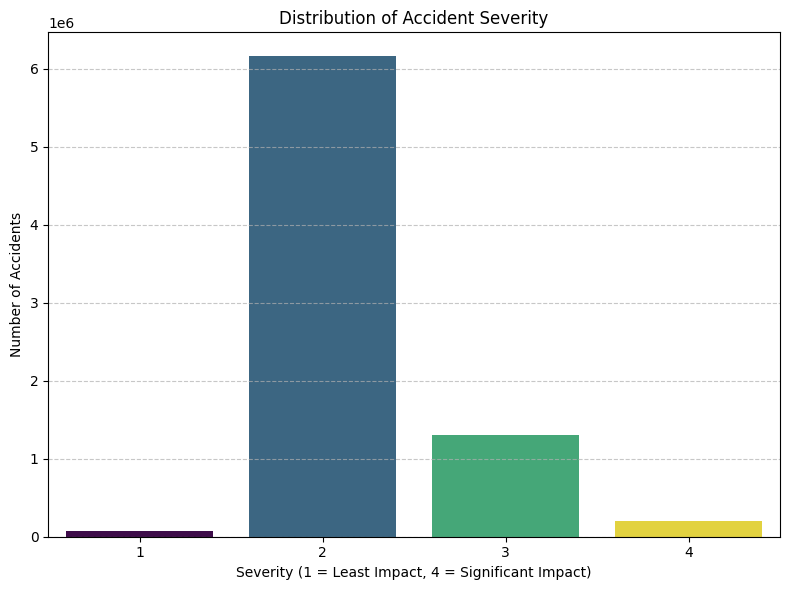

In [31]:
print("\n--- Analyzing Severity Distribution ---")

severity_counts_spark = df.groupBy("Severity").count().orderBy("Severity")
severity_counts_pd = severity_counts_spark.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x='Severity', y='count', data=severity_counts_pd, hue='Severity', palette='viridis', legend=False)

plt.title('Distribution of Accident Severity')
plt.xlabel('Severity (1 = Least Impact, 4 = Significant Impact)')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Accident Severity Distribution

There are almost no Severity 1 accidents. This may be counter-intuitive, as minor accidents happen frequently. Our assumption is that most of these accidents are simply too minor to get "noticed" in this data set.

The data is dominated by Severity 2 (~6M) and 3 (1.2M) accidents, with Severity 4 as the "rarest" (technically Severity 1 is rarer in the set, but likely under-reported). 

Severity describes the effect the accident had on **traffic** patterns, so it's important to keep in mind that a very serious or even lethal accident that takes place on a street with very little traffic would likely be rated 1, or not even appear at all.


--- Analyzing Accident Frequency by Hour of Day ---


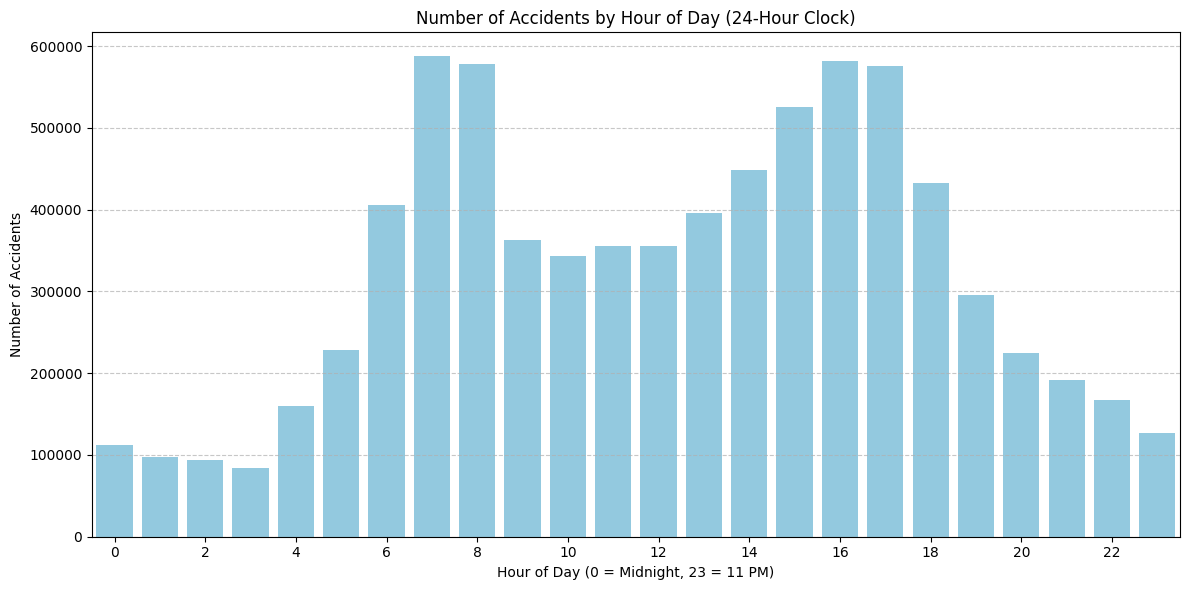

In [ ]:

print("\n--- Analyzing Accident Frequency by Hour of Day ---")

df_hourly_accidents = df.withColumn("Start_Hour", hour(col("Start_Time")))
hourly_counts_spark = df_hourly_accidents.groupBy("Start_Hour").count().orderBy("Start_Hour")

# DF for plotting our evil deeds
hourly_counts_pd = hourly_counts_spark.toPandas()

all_hours = pd.DataFrame({'Start_Hour': range(24)})
hourly_counts_pd = pd.merge(all_hours, hourly_counts_pd, on='Start_Hour', how='left').fillna(0)

plt.figure(figsize=(12, 6))
sns.barplot(x='Start_Hour', y='count', data=hourly_counts_pd, color='skyblue')

plt.title('Number of Accidents by Hour of Day (24-Hour Clock)')
plt.xlabel('Hour of Day (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Number of Accidents')
plt.xticks(range(0, 24, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#TODO - goal: use data to deconfound overall driving rates. hard to find


--- Analyzing Accident Frequency for Severity 3 by Hour of Day ---


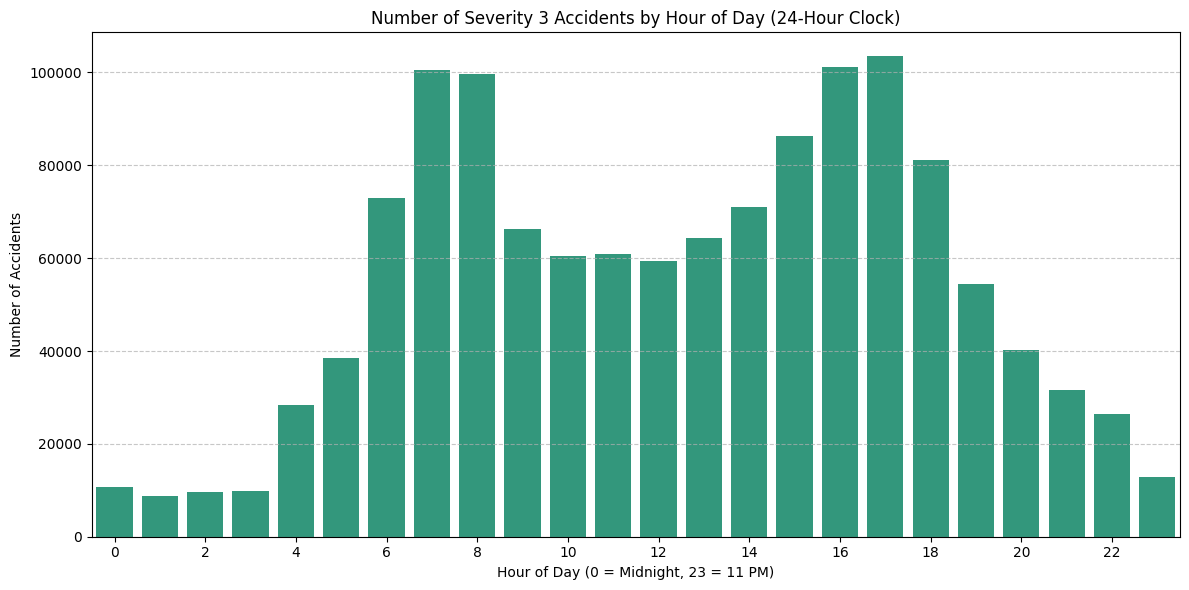


--- Analyzing Accident Frequency for Severity 4 by Hour of Day ---


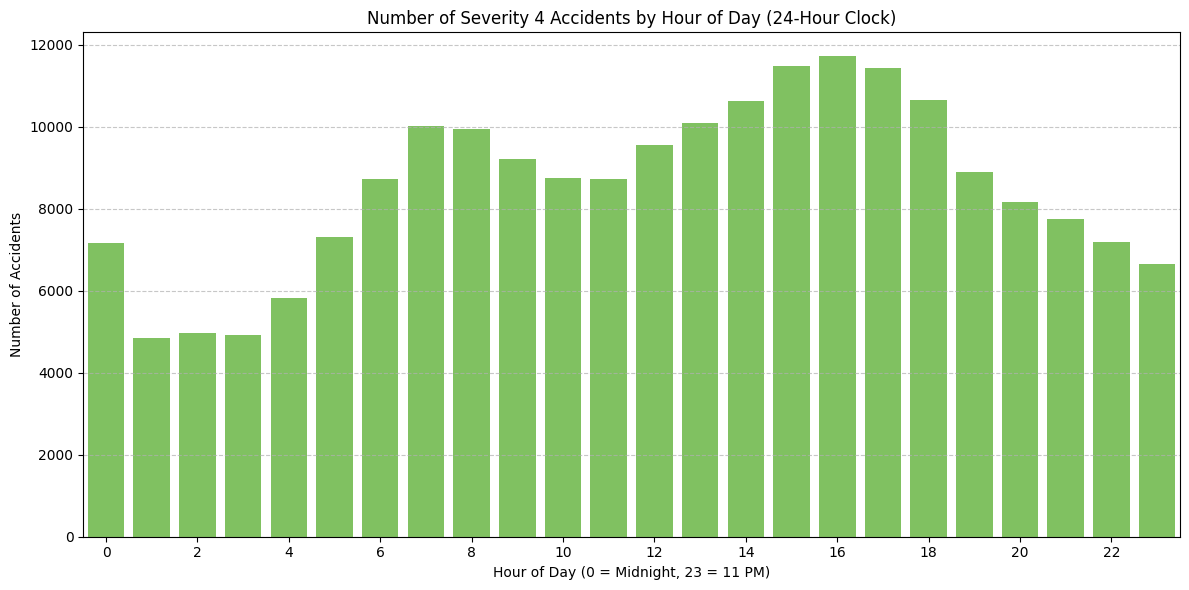

In [36]:
def plot_hourly_freq_by_sevgroup(df_spark, severity_level, plot_color):
    """
    Analyzes and plots accident frequency for a specific severity level by hour of day.
    """
    print(f"\n--- Analyzing Accident Frequency for Severity {severity_level} by Hour of Day ---")

    # Filter for the specified severity level and extract hour
    df_hourly = df_spark.filter(col("Severity") == severity_level) \
                        .withColumn("Start_Hour", hour(col("Start_Time")))

    # Count accidents per hour
    hourly_counts_spark = df_hourly.groupBy("Start_Hour").count().orderBy("Start_Hour")
    hourly_counts_pd = hourly_counts_spark.toPandas()

    # Ensure all 24 hours (0-23) are present for complete x-axis, filling missing hours with 0
    all_hours_df = pd.DataFrame({'Start_Hour': range(24)})
    hourly_counts_pd = pd.merge(all_hours_df, hourly_counts_pd, on='Start_Hour', how='left').fillna(0)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Start_Hour', y='count', data=hourly_counts_pd, color=plot_color)

    plt.title(f'Number of Severity {severity_level} Accidents by Hour of Day (24-Hour Clock)')
    plt.xlabel('Hour of Day (0 = Midnight, 23 = 11 PM)')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(0, 24, 2))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
#TODO get colors to match bar chart above
viridis_colors = sns.color_palette("viridis", 4)
sev3_color = viridis_colors[2]
sev4_color = viridis_colors[3]

plot_hourly_freq_by_sevgroup(df, 3, sev3_color)
plot_hourly_freq_by_sevgroup(df, 4, sev4_color)


--- Analyzing Accident Frequency for Severity 3 by Day of Week ---


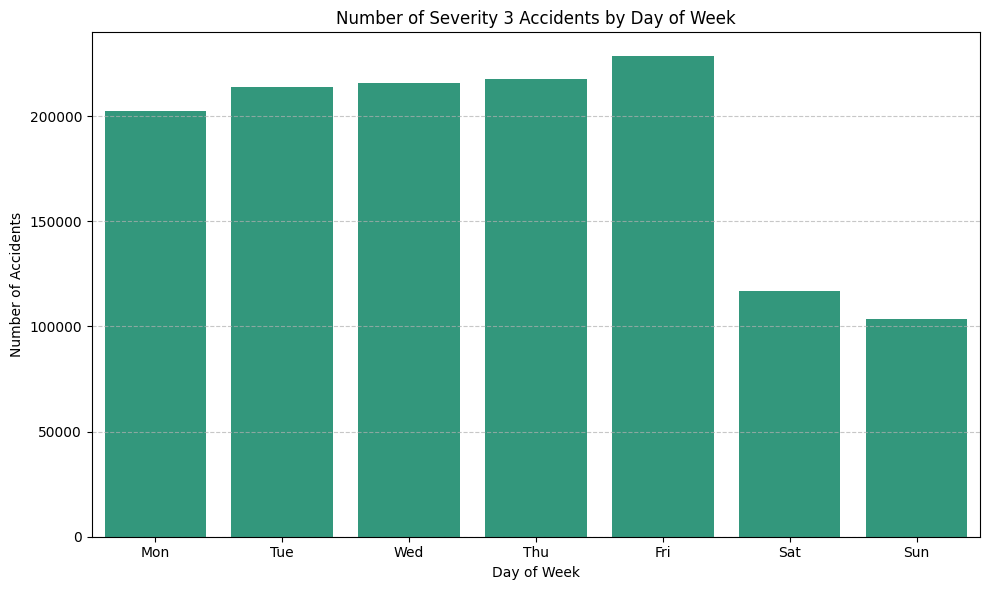


--- Analyzing Accident Frequency for Severity 4 by Day of Week ---


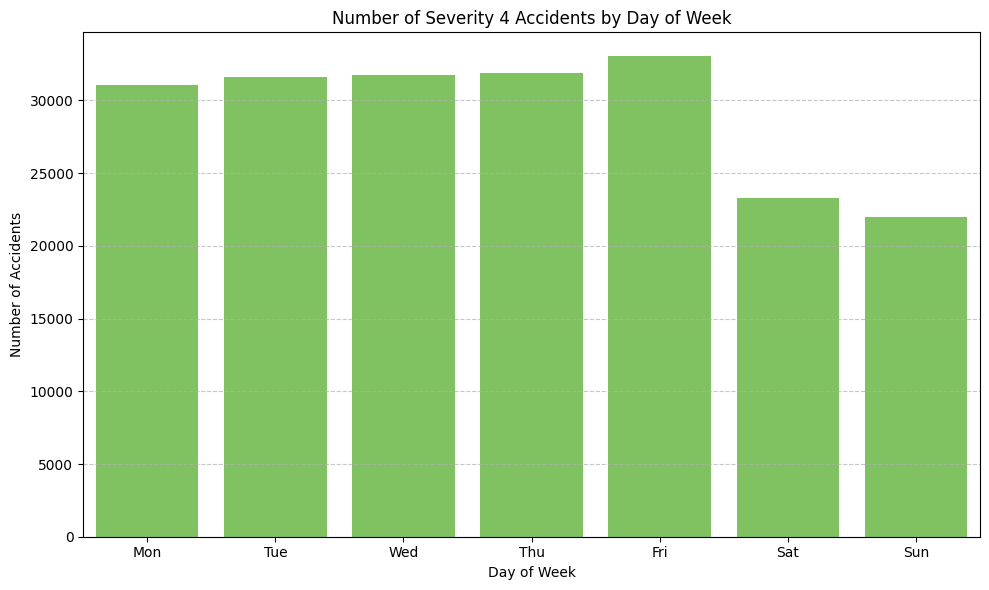

In [ ]:
def plot_daily_freq_by_sevgroup(df_spark, severity_level, plot_color):
    """
    Analyzes and plots accident distribution by day of week for a specific severity
    """
    print(f"\n--- Analyzing Accident Frequency for Severity {severity_level} by Day of Week ---")

    # Filter for the specified severity level
    df_filtered_severity = df_spark.filter(col("Severity") == severity_level) \
                                 .withColumn("Day_of_Week_Num", dayofweek(col("Start_Time"))) \
                                 .withColumn("Day_of_Week", date_format(col("Start_Time"), "E"))
                                 # "E" gives abbreviated day name (Mon, Tue)

    # Count accidents per day of week
    dow_counts_spark = df_filtered_severity.groupBy("Day_of_Week_Num", "Day_of_Week").count().orderBy("Day_of_Week_Num")
    dow_counts_pd = dow_counts_spark.toPandas()

    day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"] # Keep weekend grouped
    dow_counts_pd['Day_of_Week'] = pd.Categorical(dow_counts_pd['Day_of_Week'], categories=day_order, ordered=True)
    dow_counts_pd = dow_counts_pd.sort_values('Day_of_Week')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Day_of_Week', y='count', data=dow_counts_pd, color=plot_color)

    plt.title(f'Number of Severity {severity_level} Accidents by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Accidents')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_daily_freq_by_sevgroup(df, 3, sev3_color)
plot_daily_freq_by_sevgroup(df, 4, sev4_color)
#TODO ... and further... colors maybe don't correlate well. sev4 = light green?

### Weather EDA

In [38]:
# "For it is far more important to know whether there will be weather, than what the weather will be"
print("--- Distribution of Weather_Condition (including missing values) ---")

weather_counts_spark = df.groupBy("Weather_Condition").count().orderBy(col("count").desc())
weather_counts_pd = weather_counts_spark.toPandas()

weather_counts_pd['Weather_Condition'] = weather_counts_pd['Weather_Condition'].fillna('Missing')

num_unique_conditions = len(weather_counts_pd['Weather_Condition'].unique())
print(f"Number of unique weather conditions (including 'Missing'): {num_unique_conditions}")

print("\nTop 15 Weather Conditions:")
print(weather_counts_pd.head(15))

# Print summary of missing values
missing_weather_count = df.filter(col("Weather_Condition").isNull()).count()
total_records = df.count()
missing_percentage = (missing_weather_count / total_records) * 100 if total_records > 0 else 0
print(f"\nMissing Weather_Condition values: {missing_weather_count} out of {total_records} ({missing_percentage:.2f}%)")


--- Distribution of Weather_Condition (including missing values) ---


Number of unique weather conditions (including 'Missing'): 145

Top 15 Weather Conditions:
   Weather_Condition    count
0               Fair  2560802
1      Mostly Cloudy  1016195
2             Cloudy   817082
3              Clear   808743
4      Partly Cloudy   698972
5           Overcast   382866
6         Light Rain   352957
7   Scattered Clouds   204829
8            Missing   173459
9         Light Snow   128680
10               Fog    99238
11              Rain    84331
12              Haze    76223
13      Fair / Windy    35671
14        Heavy Rain    32309



Missing Weather_Condition values: 173459 out of 7728394 (2.24%)


In [ ]:

# Initial weather category groupings provided by Gemini (145 categories is a lot for a human to process)

# Define the explicit mapping for consolidation
# Order matters: more specific matches should generally come before broader ones if there's overlap in logic
weather_consolidation_map = {
    # 1. Missing (handled first by isNull check)
    # 'Missing': 'Missing', # This will be the fillna target for original nulls

    # 2. Clear/Fair
    'Fair': 'Clear',
    'Clear': 'Clear',

    # 3. Cloudy
    'Mostly Cloudy': 'Cloudy',
    'Cloudy': 'Cloudy',
    'Partly Cloudy': 'Cloudy',
    'Overcast': 'Cloudy',
    'Scattered Clouds': 'Cloudy',

    # 4. Light Rain/Drizzle
    'Light Rain': 'Light Rain/Drizzle',
    'Light Drizzle': 'Light Rain/Drizzle',
    'Drizzle': 'Light Rain/Drizzle',
    'Light Rain Shower': 'Light Rain/Drizzle',
    'Light Rain Showers': 'Light Rain/Drizzle',
    'Rain Showers': 'Light Rain/Drizzle',
    'Rain Shower': 'Light Rain/Drizzle',
    'Showers in the Vicinity': 'Light Rain/Drizzle', # Small count, but semantically fits

    # 5. Rain (Moderate/Heavy)
    'Rain': 'Rain (Moderate/Heavy)',
    'Heavy Rain': 'Rain (Moderate/Heavy)',
    'Heavy Rain Showers': 'Rain (Moderate/Heavy)',
    'Heavy Rain Shower': 'Rain (Moderate/Heavy)',

    # 6. Light Snow
    'Light Snow': 'Light Snow',
    'Light Snow Shower': 'Light Snow',
    'Light Snow Showers': 'Light Snow',

    # 7. Snow (Moderate/Heavy)
    'Snow': 'Snow (Moderate/Heavy)',
    'Heavy Snow': 'Snow (Moderate/Heavy)',

    # 8. Fog/Mist/Haze
    'Fog': 'Fog/Mist/Haze',
    'Haze': 'Fog/Mist/Haze',
    'Patches of Fog': 'Fog/Mist/Haze',
    'Mist': 'Fog/Mist/Haze',
    'Shallow Fog': 'Fog/Mist/Haze',
    'Partial Fog': 'Fog/Mist/Haze',
    'Light Fog': 'Fog/Mist/Haze',
    'Light Haze': 'Fog/Mist/Haze',
    'Drizzle and Fog': 'Fog/Mist/Haze',

    # 9. Thunderstorm (General)
    'Thunder in the Vicinity': 'Thunderstorm',
    'T-Storm': 'Thunderstorm',
    'Thunder': 'Thunderstorm',
    'Thunderstorm': 'Thunderstorm',
    'Light Thunderstorm': 'Thunderstorm',

    # 10. Thunderstorm with Precip/Hail
    'Light Rain with Thunder': 'Thunderstorm with Precip/Hail',
    'Heavy T-Storm': 'Thunderstorm with Precip/Hail',
    'Light Thunderstorms and Rain': 'Thunderstorm with Precip/Hail',
    'Heavy Thunderstorms and Rain': 'Thunderstorm with Precip/Hail',
    'Thunderstorms and Rain': 'Thunderstorm with Precip/Hail',
    'Snow and Thunder': 'Thunderstorm with Precip/Hail',
    'Light Snow with Thunder': 'Thunderstorm with Precip/Hail',
    'Heavy Snow with Thunder': 'Thunderstorm with Precip/Hail',
    'Thunderstorms and Snow': 'Thunderstorm with Precip/Hail',
    'Light Thunderstorms and Snow': 'Thunderstorm with Precip/Hail',
    'Thunder and Hail': 'Thunderstorm with Precip/Hail',
    'Heavy Thunderstorms with Small Hail': 'Thunderstorm with Precip/Hail', # Small Hail is also hail

    # 11. Wintry Mix/Sleet/Ice
    'Wintry Mix': 'Wintry Mix/Sleet/Ice',
    'Snow and Sleet': 'Wintry Mix/Sleet/Ice',
    'Light Snow and Sleet': 'Wintry Mix/Sleet/Ice',
    'Sleet': 'Wintry Mix/Sleet/Ice',
    'Light Sleet': 'Wintry Mix/Sleet/Ice',
    'Heavy Sleet': 'Wintry Mix/Sleet/Ice',
    'Freezing Rain': 'Wintry Mix/Sleet/Ice',
    'Light Freezing Rain': 'Wintry Mix/Sleet/Ice',
    'Freezing Drizzle': 'Wintry Mix/Sleet/Ice',
    'Light Freezing Drizzle': 'Wintry Mix/Sleet/Ice',
    'Heavy Freezing Rain': 'Wintry Mix/Sleet/Ice',
    'Heavy Freezing Drizzle': 'Wintry Mix/Sleet/Ice',
    'Light Ice Pellets': 'Wintry Mix/Sleet/Ice',
    'Ice Pellets': 'Wintry Mix/Sleet/Ice',
    'Heavy Ice Pellets': 'Wintry Mix/Sleet/Ice',
    'Snow Grains': 'Wintry Mix/Sleet/Ice',
    'Light Snow Grains': 'Wintry Mix/Sleet/Ice',
    'Rain and Sleet': 'Wintry Mix/Sleet/Ice',
    'Thunder / Wintry Mix': 'Wintry Mix/Sleet/Ice',
    'Sleet and Thunder': 'Wintry Mix/Sleet/Ice',
    'Heavy Sleet and Thunder': 'Wintry Mix/Sleet/Ice',

    # 12. Windy (Clear/Cloudy) - these are common enough to stay somewhat distinct
    'Fair / Windy': 'Windy (Clear/Cloudy)',
    'Cloudy / Windy': 'Windy (Clear/Cloudy)',
    'Mostly Cloudy / Windy': 'Windy (Clear/Cloudy)',
    'Partly Cloudy / Windy': 'Windy (Clear/Cloudy)',

    # 13. Dust/Sand/Smoke
    'Smoke': 'Dust/Sand/Smoke',
    'Blowing Dust': 'Dust/Sand/Smoke',
    'Widespread Dust': 'Dust/Sand/Smoke',
    'Sand': 'Dust/Sand/Smoke',
    'Duststorm': 'Dust/Sand/Smoke',
    'Blowing Sand': 'Dust/Sand/Smoke',
    'Dust Whirls': 'Dust/Sand/Smoke',
    'Sand / Dust Whirlwinds': 'Dust/Sand/Smoke',
    'Sand / Dust Whirls Nearby': 'Dust/Sand/Smoke',
    'Heavy Smoke': 'Dust/Sand/Smoke',

    # 14. Rare/Extreme - explicit mapping for distinct severe events
    'Tornado': 'Rare/Extreme',
    'Funnel Cloud': 'Rare/Extreme',
    'Volcanic Ash': 'Rare/Extreme',
    'Squalls': 'Rare/Extreme',
    'Small Hail': 'Rare/Extreme', # Already handled by Thunderstorm with Precip/Hail above if it occurs with it, but here for standalone
    'Hail': 'Rare/Extreme', # Handled by Thunderstorm with Precip/Hail, but here if standalone

    # Other compound windy/blowing conditions not already captured in specific categories, or N/A
    # These will be caught by the general 'Windy (Other Precip/Conditions)' or 'Other Minor'
    'Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Light Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Light Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Light Freezing Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Light Freezing Drizzle / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy T-Storm / Windy': 'Windy (Other Precip/Conditions)',
    'T-Storm / Windy': 'Windy (Other Precip/Conditions)',
    'Fog / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Thunder / Windy': 'Windy (Other Precip/Conditions)',
    'Wintry Mix / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Dust / Windy': 'Windy (Other Precip/Conditions)',
    'Light Drizzle / Windy': 'Windy (Other Precip/Conditions)',
    'Snow and Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Smoke / Windy': 'Windy (Other Precip/Conditions)',
    'Squalls / Windy': 'Windy (Other Precip/Conditions)',
    'Light Snow and Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Freezing Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Widespread Dust / Windy': 'Windy (Other Precip/Conditions)',
    'Drizzle / Windy': 'Windy (Other Precip/Conditions)',
    'Light Rain Shower / Windy': 'Windy (Other Precip/Conditions)',
    'Mist / Windy': 'Windy (Other Precip/Conditions)',
    'Light Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Thunder and Hail / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Freezing Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Patches of Fog / Windy': 'Windy (Other Precip/Conditions)',
    'Shallow Fog / Windy': 'Windy (Other Precip/Conditions)',
    'Sand / Dust Whirlwinds / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Blowing Snow': 'Windy (Other Precip/Conditions)', # No '/ Windy', but implies wind
    'Light Blowing Snow': 'Windy (Other Precip/Conditions)',
    'Rain Shower / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Rain Shower / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Sand': 'Windy (Other Precip/Conditions)', # Already in Dust/Sand/Smoke but also windy
    'Snow and Thunder / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Sleet and Thunder / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Snow Nearby': 'Windy (Other Precip/Conditions)',
    'Drifting Snow': 'Windy (Other Precip/Conditions)',
    'Drifting Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Low Drifting Snow': 'Windy (Other Precip/Conditions)',
    'Sand / Windy': 'Windy (Other Precip/Conditions)',

    'N/A Precipitation': 'Other/Unspecified', # Non-weather related category
}

# Build the PySpark conditional expression for the new column
# Start by handling nulls, then iterate through the defined map.
# Conditions not explicitly mapped will fall into 'Other Minor'
consolidated_weather_col_expr = when(col("Weather_Condition").isNull(), "Missing")

# Add all explicit mappings
for original_cond, new_cat in weather_consolidation_map.items():
    consolidated_weather_col_expr = consolidated_weather_col_expr.when(
        col("Weather_Condition") == original_cond,
        lit(new_cat)
    )

# For any conditions not explicitly mapped above (and not null), they will be 'Other Minor'
# This implicitly handles any conditions with counts < 100 that were not explicitly mapped.
consolidated_weather_col_expr = consolidated_weather_col_expr.otherwise("Other Minor")

# Add the new consolidated column to the DataFrame
df_categorized_weather = df.withColumn("Consolidated_Weather", consolidated_weather_col_expr)

# Verify the new categories and their counts
print("\n--- Consolidated Weather Condition Categories ---")
consolidated_counts = df_categorized_weather.groupBy("Consolidated_Weather").count().orderBy(col("count").desc())
consolidated_counts.show(truncate=False)

print(f"\nNumber of consolidated categories: {consolidated_counts.count()}")


--- Consolidated Weather Condition Categories ---


+-------------------------------+-------+
|Consolidated_Weather           |count  |
+-------------------------------+-------+
|Clear                          |3369545|
|Cloudy                         |3119944|
|Light Rain/Drizzle             |382479 |
|Fog/Mist/Haze                  |186659 |
|Missing                        |173459 |
|Light Snow                     |128748 |
|Rain (Moderate/Heavy)          |116650 |
|Windy (Clear/Cloudy)           |79455  |
|Thunderstorm                   |53064  |
|Thunderstorm with Precip/Hail  |33014  |
|Windy (Other Precip/Conditions)|26380  |
|Snow (Moderate/Heavy)          |20540  |
|Wintry Mix/Sleet/Ice           |18060  |
|Dust/Sand/Smoke                |13119  |
|Other Minor                    |3814   |
|Other/Unspecified              |3252   |
|Rare/Extreme                   |212    |
+-------------------------------+-------+




Number of consolidated categories: 17


--- Heatmap: Consolidated Weather Condition vs. Accident Severity ---


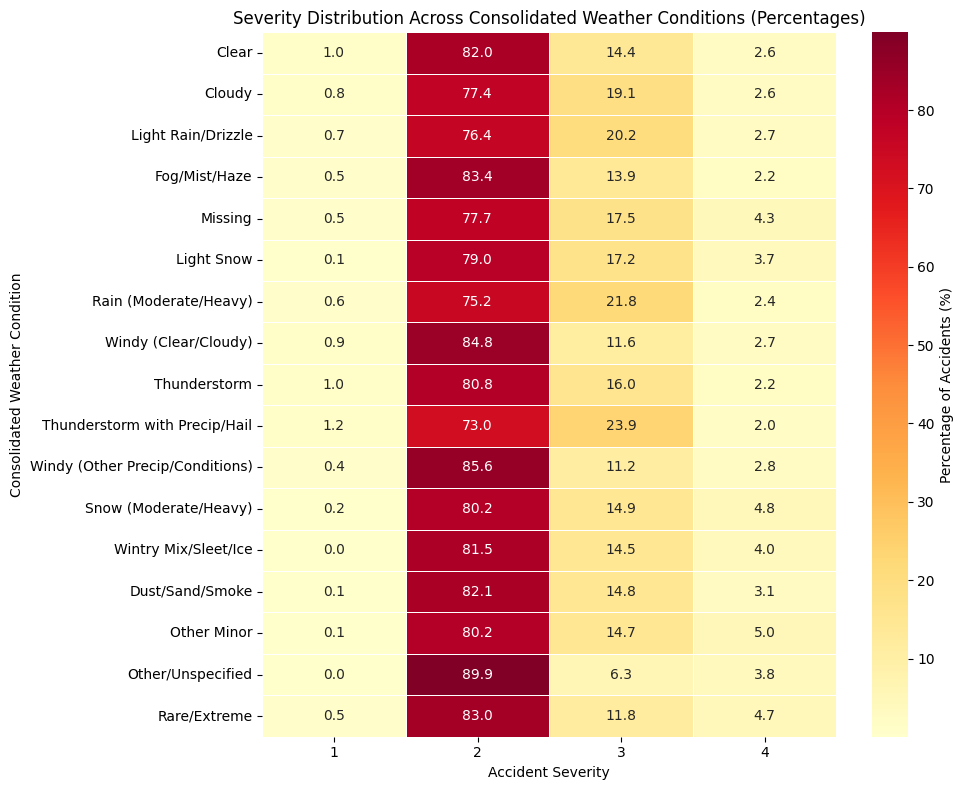

In [23]:
print("--- Heatmap: Consolidated Weather Condition vs. Accident Severity ---")

# Calculate counts for each Consolidated_Weather and Severity combination
severity_weather_counts = df_categorized_weather.groupBy("Consolidated_Weather", "Severity").count().orderBy("Consolidated_Weather", "Severity")

# Convert to Pandas DataFrame for easier pivoting and plotting
severity_weather_pd = severity_weather_counts.toPandas()

# Pivot the DataFrame to get weather conditions as index and severity as columns
# Fill any missing combinations with 0
pivot_table = severity_weather_pd.pivot_table(
    index='Consolidated_Weather',
    columns='Severity',
    values='count',
    fill_value=0
)

# Calculate proportions of each severity within each weather condition
# Sum across rows (severities for a given weather condition)
pivot_table_proportions = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100 # Convert to percentage

# Ensure severity columns are ordered correctly (1, 2, 3, 4)
ordered_columns = [1, 2, 3, 4]
pivot_table_proportions = pivot_table_proportions[ordered_columns]

# Sort the index (Weather Conditions) by total count for better readability in the heatmap
# This puts the most common weather conditions at the top
sorted_weather_conditions = df_categorized_weather.groupBy("Consolidated_Weather").count().toPandas()
sorted_weather_conditions = sorted_weather_conditions.set_index("Consolidated_Weather").loc[pivot_table_proportions.index] # Align index
pivot_table_proportions = pivot_table_proportions.loc[sorted_weather_conditions['count'].sort_values(ascending=False).index]


# Create the heatmap
plt.figure(figsize=(10, 8)) # Adjust size as needed for 17 rows x 4 columns
sns.heatmap(
    pivot_table_proportions,
    annot=True,     # Show the percentage values on the heatmap
    fmt=".1f",      # Format annotations to one decimal place
    cmap="YlOrRd",  # Color map (Yellow-Orange-Red, good for showing intensity)
    linewidths=.5,  # Add lines between cells
    cbar_kws={'label': 'Percentage of Accidents (%)'} # Color bar label
)

plt.title('Severity Distribution Across Consolidated Weather Conditions (Percentages)')
plt.xlabel('Accident Severity')
plt.ylabel('Consolidated Weather Condition')
plt.yticks(rotation=0) # Keep Y-labels horizontal
plt.tight_layout()
plt.show()

--- Heatmap: Lift of Accident Severity by Consolidated Weather Condition ---



Global Severity Proportions:
Severity
1    0.008717
3    0.168125
4    0.026488
2    0.796670
Name: count, dtype: float64


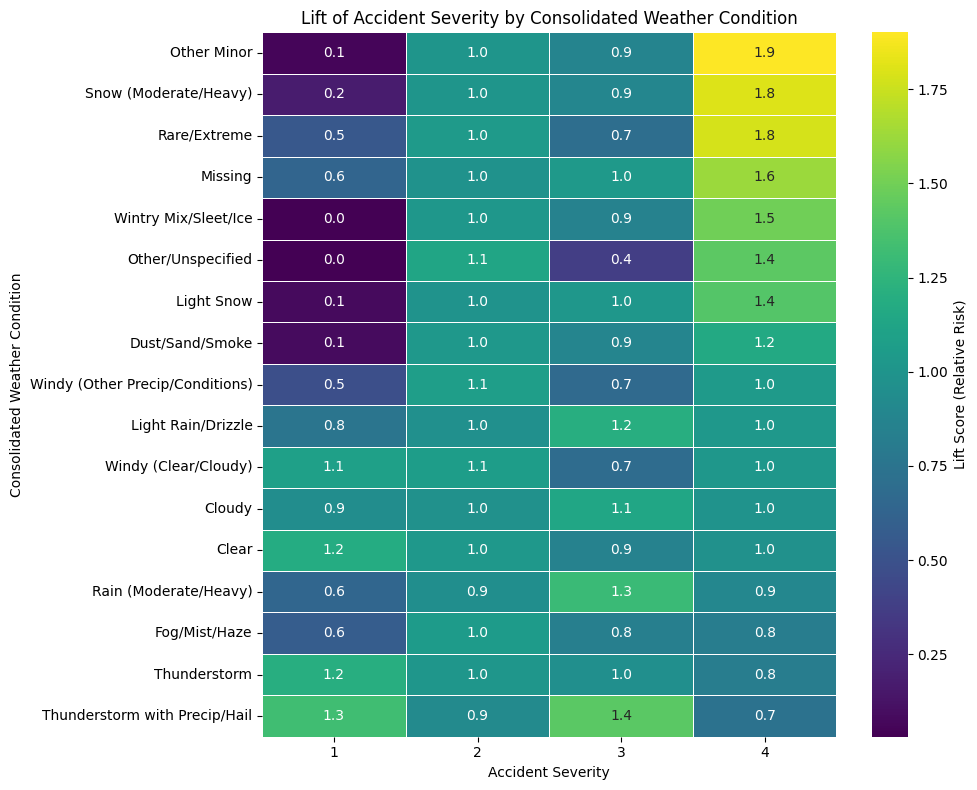


Lift Table (sorted by Severity 4, then Severity 3 lift):
Severity                                1         2         3         4
Consolidated_Weather                                                   
Other Minor                      0.060159  1.007076  0.873323  1.900513
Snow (Moderate/Heavy)            0.173145  1.006319  0.886401  1.803096
Rare/Extreme                     0.541144  1.042073  0.701409  1.780797
Missing                          0.630957  0.975334  1.038823  1.616902
Wintry Mix/Sleet/Ice             0.031761  1.023015  0.862552  1.498827
Other/Unspecified                0.035278  1.128621  0.373119  1.427923
Light Snow                       0.076631  0.992057  1.022833  1.397832
Dust/Sand/Smoke                  0.087448  1.030185  0.879113  1.159724
Windy (Other Precip/Conditions)  0.478373  1.074269  0.668074  1.044716
Light Rain/Drizzle               0.756160  0.959477  1.200246  1.028021
Windy (Clear/Cloudy)             1.088676  1.064196  0.687958  1.020618
Cloudy

In [24]:
print("--- Heatmap: Lift of Accident Severity by Consolidated Weather Condition ---")

# 1. Calculate overall prevalence of each Severity level
global_severity_counts_spark = df_categorized_weather.groupBy("Severity").count()
global_severity_counts_pd = global_severity_counts_spark.toPandas()
total_accidents = global_severity_counts_pd['count'].sum()
global_severity_proportions = global_severity_counts_pd.set_index('Severity')['count'] / total_accidents

print("\nGlobal Severity Proportions:")
print(global_severity_proportions)

# 2. Calculate counts for each Consolidated_Weather and Severity combination (as before)
severity_weather_counts = df_categorized_weather.groupBy("Consolidated_Weather", "Severity").count().orderBy("Consolidated_Weather", "Severity")
severity_weather_pd = severity_weather_counts.toPandas()

# 3. Pivot the DataFrame to get weather conditions as index and severity as columns
pivot_table = severity_weather_pd.pivot_table(
    index='Consolidated_Weather',
    columns='Severity',
    values='count',
    fill_value=0
)

# 4. Calculate P(Severity | Weather_Condition) - proportions within each weather condition
pivot_table_conditional_prob = pivot_table.div(pivot_table.sum(axis=1), axis=0) # Already in decimal, not percentage for lift calc

# 5. Calculate Lift Score for each cell: P(Severity | Weather) / P(Severity)
lift_table = pivot_table_conditional_prob.copy()
for severity_level in global_severity_proportions.index:
    if severity_level in lift_table.columns and global_severity_proportions[severity_level] > 0:
        lift_table[severity_level] = lift_table[severity_level] / global_severity_proportions[severity_level]
    else:
        # Handle cases where global proportion is 0 (shouldn't happen for 1-4) or column missing
        lift_table[severity_level] = 0 # Or handle as NaN if preferred

# Ensure severity columns are ordered correctly (1, 2, 3, 4) for consistent plotting
ordered_columns = [1, 2, 3, 4]
if all(col_name in lift_table.columns for col_name in ordered_columns):
    lift_table = lift_table[ordered_columns]
else:
    # Handle case where some severity levels might be missing (e.g., if a weather condition never had Sev1)
    # This might happen if original data is sparse or small. For our large dataset, unlikely.
    # If it happens, we'd fill missing columns with 0.
    for col_name in ordered_columns:
        if col_name not in lift_table.columns:
            lift_table[col_name] = 0
    lift_table = lift_table[ordered_columns] # Re-order


# Sort the index (Consolidated Weather Conditions) by the lift of higher severities for better insights
# We can sort by the lift of Severity 4, then Severity 3, to highlight the most "dangerous" conditions
lift_table_sorted = lift_table.sort_values(by=[4, 3], ascending=[False, False])


# Create the heatmap
plt.figure(figsize=(10, 8)) # Adjust size as needed for 17 rows x 4 columns
sns.heatmap(
    lift_table_sorted,
    annot=True,     # Show the lift values on the heatmap
    fmt=".1f",      # Format annotations to one decimal place
    cmap="viridis",  # Color map (often good for quantitative scales, "YlGnBu" or "OrRd" also work)
    linewidths=.5,  # Add lines between cells
    cbar_kws={'label': 'Lift Score (Relative Risk)'} # Color bar label
)

plt.title('Lift of Accident Severity by Consolidated Weather Condition')
plt.xlabel('Accident Severity')
plt.ylabel('Consolidated Weather Condition')
plt.yticks(rotation=0) # Keep Y-labels horizontal
plt.tight_layout()
plt.show()

print("\nLift Table (sorted by Severity 4, then Severity 3 lift):")
print(lift_table_sorted)

In [25]:
from pyspark.sql.functions import col, when, lit, count

# --- PART 1: Display Consolidated Weather Category Counts ---
# Re-use the consolidated_counts DataFrame from the previous step
# df_categorized_weather is the DataFrame with the 'Consolidated_Weather' column
consolidated_counts = df_categorized_weather.groupBy("Consolidated_Weather").count().orderBy(col("count").desc())

print("--- Consolidated Weather Category Counts (Ordered by Frequency) ---")
consolidated_counts.show(n=20, truncate=False) # Show all 17 categories

# --- PART 2: Investigate "Other Minor" Category Contents ---
print("\n--- Original Weather Conditions within 'Other Minor' Category ---")

# First, define the mapping to re-create the "Other Minor" condition if needed.
# This assumes weather_consolidation_map is defined as in the previous step.
# If weather_consolidation_map was not kept, you'd need to re-run its definition.

# Get the list of conditions that *should* be 'Other Minor' based on our rules
# For this, we filter df_categorized_weather for 'Other Minor' and then check their original conditions.
other_minor_original_conditions_spark = df_categorized_weather.filter(col("Consolidated_Weather") == "Other Minor") \
                                            .groupBy("Weather_Condition").count() \
                                            .orderBy(col("count").desc())

# Convert to Pandas for display
other_minor_original_conditions_pd = other_minor_original_conditions_spark.toPandas()

print(other_minor_original_conditions_pd.to_string()) # .to_string() for full display if many rows
print(f"\nTotal unique original conditions in 'Other Minor': {len(other_minor_original_conditions_pd)}")
print(f"Total count for 'Other Minor' category: {other_minor_original_conditions_pd['count'].sum()}")

--- Consolidated Weather Category Counts (Ordered by Frequency) ---


+-------------------------------+-------+
|Consolidated_Weather           |count  |
+-------------------------------+-------+
|Clear                          |3369545|
|Cloudy                         |3119944|
|Light Rain/Drizzle             |382479 |
|Fog/Mist/Haze                  |186659 |
|Missing                        |173459 |
|Light Snow                     |128748 |
|Rain (Moderate/Heavy)          |116650 |
|Windy (Clear/Cloudy)           |79455  |
|Thunderstorm                   |53064  |
|Thunderstorm with Precip/Hail  |33014  |
|Windy (Other Precip/Conditions)|26380  |
|Snow (Moderate/Heavy)          |20540  |
|Wintry Mix/Sleet/Ice           |18060  |
|Dust/Sand/Smoke                |13119  |
|Other Minor                    |3814   |
|Other/Unspecified              |3252   |
|Rare/Extreme                   |212    |
+-------------------------------+-------+


--- Original Weather Conditions within 'Other Minor' Category ---


              Weather_Condition  count
0                  Haze / Windy   1595
1            Light Freezing Fog   1001
2                  Blowing Snow    740
3                 Heavy Drizzle    452
4  Thunder / Wintry Mix / Windy     10
5  Heavy Thunderstorms and Snow      5
6     Light Snow Shower / Windy      5
7                    Light Hail      3
8                  Snow Showers      2
9           Partial Fog / Windy      1

Total unique original conditions in 'Other Minor': 10
Total count for 'Other Minor' category: 3814


In [27]:
spark.stop()
print("\nSpark Session stopped.")


Spark Session stopped.


25/06/03 17:51:45 WARN DiskBlockObjectWriter: Error deleting /tmp/blockmgr-7c78985f-91dd-4678-bf41-04a3cef0ce4c/12/temp_shuffle_ae495e05-2cee-4c3b-89a9-32bc77fa8491
25/06/03 17:51:45 ERROR Executor: Exception in task 14.0 in stage 154.0 (TID 727): /tmp/blockmgr-7c78985f-91dd-4678-bf41-04a3cef0ce4c/12/temp_shuffle_ae495e05-2cee-4c3b-89a9-32bc77fa8491 (No such file or directory)


25/06/03 17:51:46 WARN DiskBlockObjectWriter: Error deleting /tmp/blockmgr-7c78985f-91dd-4678-bf41-04a3cef0ce4c/17/temp_shuffle_6215a44f-35b6-42f8-880b-6b45d73e9aba
25/06/03 17:51:46 ERROR Executor: Exception in task 15.0 in stage 154.0 (TID 728): /tmp/blockmgr-7c78985f-91dd-4678-bf41-04a3cef0ce4c/17/temp_shuffle_6215a44f-35b6-42f8-880b-6b45d73e9aba (No such file or directory)
25/06/03 17:51:46 WARN DiskBlockObjectWriter: Error deleting /tmp/blockmgr-7c78985f-91dd-4678-bf41-04a3cef0ce4c/24/temp_shuffle_3aaf27c4-77b8-4465-b529-a49f3630080c
25/06/03 17:51:46 ERROR Executor: Exception in task 16.0 in stage 154.0 (TID 729): /tmp/blockmgr-7c78985f-91dd-4678-bf41-04a3cef0ce4c/24/temp_shuffle_3aaf27c4-77b8-4465-b529-a49f3630080c (No such file or directory)
25/06/03 17:51:46 WARN DiskBlockObjectWriter: Error deleting /tmp/blockmgr-7c78985f-91dd-4678-bf41-04a3cef0ce4c/34/temp_shuffle_b3024f93-25f3-4458-a53f-7eafe6085416
25/06/03 17:51:46 ERROR Executor: Exception in task 18.0 in stage 154.0 (TI

In [ ]:
from pyspark.sql.functions import col, when, lit, count

# Define the updated consolidation map with corrected mappings for the problematic "Other Minor" entries
weather_consolidation_map_revised = {
    # 1. Missing (handled first by isNull check)

    # 2. Clear/Fair
    'Fair': 'Clear',
    'Clear': 'Clear',

    # 3. Cloudy
    'Mostly Cloudy': 'Cloudy',
    'Cloudy': 'Cloudy',
    'Partly Cloudy': 'Cloudy',
    'Overcast': 'Cloudy',
    'Scattered Clouds': 'Cloudy',

    # 4. Light Rain/Drizzle
    'Light Rain': 'Light Rain/Drizzle',
    'Light Drizzle': 'Light Rain/Drizzle',
    'Drizzle': 'Light Rain/Drizzle',
    'Light Rain Shower': 'Light Rain/Drizzle',
    'Light Rain Showers': 'Light Rain/Drizzle',
    'Rain Showers': 'Light Rain/Drizzle',
    'Rain Shower': 'Light Rain/Drizzle',
    'Showers in the Vicinity': 'Light Rain/Drizzle',

    # 5. Rain (Moderate/Heavy)
    'Rain': 'Rain (Moderate/Heavy)',
    'Heavy Rain': 'Rain (Moderate/Heavy)',
    'Heavy Rain Showers': 'Rain (Moderate/Heavy)',
    'Heavy Rain Shower': 'Rain (Moderate/Heavy)',
    'Heavy Drizzle': 'Rain (Moderate/Heavy)', # MOVED from Other Minor

    # 6. Light Snow
    'Light Snow': 'Light Snow',
    'Light Snow Shower': 'Light Snow',
    'Light Snow Showers': 'Light Snow',
    'Snow Showers': 'Light Snow', # MOVED from Other Minor

    # 7. Snow (Moderate/Heavy)
    'Snow': 'Snow (Moderate/Heavy)',
    'Heavy Snow': 'Snow (Moderate/Heavy)',
    'Blowing Snow': 'Snow (Moderate/Heavy)', # MOVED from Other Minor

    # 8. Fog/Mist/Haze
    'Fog': 'Fog/Mist/Haze',
    'Haze': 'Fog/Mist/Haze',
    'Patches of Fog': 'Fog/Mist/Haze',
    'Mist': 'Fog/Mist/Haze',
    'Shallow Fog': 'Fog/Mist/Haze',
    'Partial Fog': 'Fog/Mist/Haze',
    'Light Fog': 'Fog/Mist/Haze',
    'Light Haze': 'Fog/Mist/Haze',
    'Drizzle and Fog': 'Fog/Mist/Haze',
    'Haze / Windy': 'Fog/Mist/Haze', # MOVED from Other Minor

    # 9. Thunderstorm (General)
    'Thunder in the Vicinity': 'Thunderstorm',
    'T-Storm': 'Thunderstorm',
    'Thunder': 'Thunderstorm',
    'Thunderstorm': 'Thunderstorm',
    'Light Thunderstorm': 'Thunderstorm',

    # 10. Thunderstorm with Precip/Hail
    'Light Rain with Thunder': 'Thunderstorm with Precip/Hail',
    'Heavy T-Storm': 'Thunderstorm with Precip/Hail',
    'Light Thunderstorms and Rain': 'Thunderstorm with Precip/Hail',
    'Heavy Thunderstorms and Rain': 'Thunderstorm with Precip/Hail',
    'Thunderstorms and Rain': 'Thunderstorm with Precip/Hail',
    'Snow and Thunder': 'Thunderstorm with Precip/Hail',
    'Light Snow with Thunder': 'Thunderstorm with Precip/Hail',
    'Heavy Snow with Thunder': 'Thunderstorm with Precip/Hail',
    'Thunderstorms and Snow': 'Thunderstorm with Precip/Hail',
    'Light Thunderstorms and Snow': 'Thunderstorm with Precip/Hail',
    'Thunder and Hail': 'Thunderstorm with Precip/Hail',
    'Heavy Thunderstorms with Small Hail': 'Thunderstorm with Precip/Hail',
    'Heavy Thunderstorms and Snow': 'Thunderstorm with Precip/Hail', # MOVED from Other Minor

    # 11. Wintry Mix/Sleet/Ice
    'Wintry Mix': 'Wintry Mix/Sleet/Ice',
    'Snow and Sleet': 'Wintry Mix/Sleet/Ice',
    'Light Snow and Sleet': 'Wintry Mix/Sleet/Ice',
    'Sleet': 'Wintry Mix/Sleet/Ice',
    'Light Sleet': 'Wintry Mix/Sleet/Ice',
    'Heavy Sleet': 'Wintry Mix/Sleet/Ice',
    'Freezing Rain': 'Wintry Mix/Sleet/Ice',
    'Light Freezing Rain': 'Wintry Mix/Sleet/Ice',
    'Freezing Drizzle': 'Wintry Mix/Sleet/Ice',
    'Light Freezing Drizzle': 'Wintry Mix/Sleet/Ice',
    'Heavy Freezing Rain': 'Wintry Mix/Sleet/Ice',
    'Heavy Freezing Drizzle': 'Wintry Mix/Sleet/Ice',
    'Light Ice Pellets': 'Wintry Mix/Sleet/Ice',
    'Ice Pellets': 'Wintry Mix/Sleet/Ice',
    'Heavy Ice Pellets': 'Wintry Mix/Sleet/Ice',
    'Snow Grains': 'Wintry Mix/Sleet/Ice',
    'Light Snow Grains': 'Wintry Mix/Sleet/Ice',
    'Rain and Sleet': 'Wintry Mix/Sleet/Ice',
    'Thunder / Wintry Mix': 'Wintry Mix/Sleet/Ice',
    'Sleet and Thunder': 'Wintry Mix/Sleet/Ice',
    'Heavy Sleet and Thunder': 'Wintry Mix/Sleet/Ice',
    'Light Freezing Fog': 'Wintry Mix/Sleet/Ice', # MOVED from Other Minor
    'Thunder / Wintry Mix / Windy': 'Wintry Mix/Sleet/Ice', # MOVED from Other Minor
    'Light Hail': 'Wintry Mix/Sleet/Ice', # MOVED from Other Minor
    'Small Hail': 'Wintry Mix/Sleet/Ice', # Ensure Small Hail is here too, was in Rare/Extreme before

    # 12. Windy (Clear/Cloudy) - these are common enough to stay somewhat distinct
    'Fair / Windy': 'Windy (Clear/Cloudy)',
    'Cloudy / Windy': 'Windy (Clear/Cloudy)',
    'Mostly Cloudy / Windy': 'Windy (Clear/Cloudy)',
    'Partly Cloudy / Windy': 'Windy (Clear/Cloudy)',

    # 13. Dust/Sand/Smoke
    'Smoke': 'Dust/Sand/Smoke',
    'Blowing Dust': 'Dust/Sand/Smoke',
    'Widespread Dust': 'Dust/Sand/Smoke',
    'Sand': 'Dust/Sand/Smoke',
    'Duststorm': 'Dust/Sand/Smoke',
    'Blowing Sand': 'Dust/Sand/Smoke',
    'Dust Whirls': 'Dust/Sand/Smoke',
    'Sand / Dust Whirlwinds': 'Dust/Sand/Smoke',
    'Sand / Dust Whirls Nearby': 'Dust/Sand/Smoke',
    'Heavy Smoke': 'Dust/Sand/Smoke',

    # 14. Rare/Extreme - explicit mapping for distinct severe events
    'Tornado': 'Rare/Extreme',
    'Funnel Cloud': 'Rare/Extreme',
    'Volcanic Ash': 'Rare/Extreme',
    'Squalls': 'Rare/Extreme',
    'Hail': 'Rare/Extreme', # Will be in Wintry Mix/Sleet/Ice now, ensuring consistency

    # Other compound windy/blowing conditions not already captured in specific categories
    'Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Light Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Light Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Light Freezing Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Light Freezing Drizzle / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy T-Storm / Windy': 'Windy (Other Precip/Conditions)',
    'T-Storm / Windy': 'Windy (Other Precip/Conditions)',
    'Fog / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Thunder / Windy': 'Windy (Other Precip/Conditions)',
    'Wintry Mix / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Dust / Windy': 'Windy (Other Precip/Conditions)',
    'Light Drizzle / Windy': 'Windy (Other Precip/Conditions)',
    'Snow and Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Smoke / Windy': 'Windy (Other Precip/Conditions)',
    'Squalls / Windy': 'Windy (Other Precip/Conditions)',
    'Light Snow and Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Freezing Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Widespread Dust / Windy': 'Windy (Other Precip/Conditions)',
    'Drizzle / Windy': 'Windy (Other Precip/Conditions)',
    'Light Rain Shower / Windy': 'Windy (Other Precip/Conditions)',
    'Mist / Windy': 'Windy (Other Precip/Conditions)',
    'Light Sleet / Windy': 'Windy (Other Precip/Conditions)',
    'Thunder and Hail / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Freezing Rain / Windy': 'Windy (Other Precip/Conditions)',
    'Patches of Fog / Windy': 'Windy (Other Precip/Conditions)',
    'Shallow Fog / Windy': 'Windy (Other Precip/Conditions)',
    'Sand / Dust Whirlwinds / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Blowing Snow': 'Windy (Other Precip/Conditions)',
    'Light Blowing Snow': 'Windy (Other Precip/Conditions)',
    'Rain Shower / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Rain Shower / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Sand': 'Windy (Other Precip/Conditions)', # Already in Dust/Sand/Smoke but also windy
    'Snow and Thunder / Windy': 'Windy (Other Precip/Conditions)',
    'Heavy Sleet and Thunder / Windy': 'Windy (Other Precip/Conditions)',
    'Blowing Snow Nearby': 'Windy (Other Precip/Conditions)',
    'Drifting Snow': 'Windy (Other Precip/Conditions)',
    'Drifting Snow / Windy': 'Windy (Other Precip/Conditions)',
    'Low Drifting Snow': 'Windy (Other Precip/Conditions)',
    'Sand / Windy': 'Windy (Other Precip/Conditions)',
    'Light Snow Shower / Windy': 'Windy (Other Precip/Conditions)', # MOVED from Other Minor


    'N/A Precipitation': 'Other/Unspecified',
    'Partial Fog / Windy': 'Other Minor', # Keep in Other Minor due to very low count and ambiguous combo
}

# Build the PySpark conditional expression for the new column
consolidated_weather_col_expr = when(col("Weather_Condition").isNull(), "Missing")

# Add all explicit mappings from the revised map
for original_cond, new_cat in weather_consolidation_map_revised.items():
    consolidated_weather_col_expr = consolidated_weather_col_expr.when(
        col("Weather_Condition") == original_cond,
        lit(new_cat)
    )

# The 'otherwise' clause will catch any conditions not explicitly mapped (which should now be truly rare ones)
consolidated_weather_col_expr = consolidated_weather_col_expr.otherwise("Other Minor")

# Add the new consolidated column to the DataFrame
df_categorized_weather = df.withColumn("Consolidated_Weather", consolidated_weather_col_expr)

# --- Recalculate and Replot the Heatmap using the revised categories ---
print("\n--- Heatmap: Lift of Accident Severity by REVISED Consolidated Weather Condition ---")

# 1. Calculate overall prevalence of each Severity level
global_severity_counts_spark = df_categorized_weather.groupBy("Severity").count()
global_severity_counts_pd = global_severity_counts_spark.toPandas()
total_accidents = global_severity_counts_pd['count'].sum()
global_severity_proportions = global_severity_counts_pd.set_index('Severity')['count'] / total_accidents

print("\nGlobal Severity Proportions (after revised consolidation):")
print(global_severity_proportions)

# 2. Calculate counts for each Consolidated_Weather and Severity combination
severity_weather_counts = df_categorized_weather.groupBy("Consolidated_Weather", "Severity").count().orderBy("Consolidated_Weather", "Severity")
severity_weather_pd = severity_weather_counts.toPandas()

# 3. Pivot the DataFrame
pivot_table = severity_weather_pd.pivot_table(
    index='Consolidated_Weather',
    columns='Severity',
    values='count',
    fill_value=0
)

# 4. Calculate P(Severity | Weather_Condition)
pivot_table_conditional_prob = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# 5. Calculate Lift Score
lift_table = pivot_table_conditional_prob.copy()
for severity_level in global_severity_proportions.index:
    if severity_level in lift_table.columns and global_severity_proportions[severity_level] > 0:
        lift_table[severity_level] = lift_table[severity_level] / global_severity_proportions[severity_level]
    else:
        lift_table[severity_level] = 0

# Ensure severity columns are ordered correctly
ordered_columns = [1, 2, 3, 4]
if all(col_name in lift_table.columns for col_name in ordered_columns):
    lift_table = lift_table[ordered_columns]
else:
    for col_name in ordered_columns:
        if col_name not in lift_table.columns:
            lift_table[col_name] = 0
    lift_table = lift_table[ordered_columns]

# Sort the index (Consolidated Weather Conditions) by the lift of higher severities
lift_table_sorted = lift_table.sort_values(by=[4, 3], ascending=[False, False])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    lift_table_sorted,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    linewidths=.5,
    cbar_kws={'label': 'Lift Score (Relative Risk)'}
)

plt.title('Lift of Accident Severity by Revised Consolidated Weather Condition')
plt.xlabel('Accident Severity')
plt.ylabel('Consolidated Weather Condition')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nLift Table (sorted by Severity 4, then Severity 3 lift, after revised consolidation):")
print(lift_table_sorted)

# Display revised consolidated category counts for confirmation
print("\n--- Revised Consolidated Weather Category Counts (Ordered by Frequency) ---")
df_categorized_weather.groupBy("Consolidated_Weather").count().orderBy(col("count").desc()).show(n=20, truncate=False)

### latlong

In [5]:
from pyspark.sql.functions import col, isnan, when, length, instr, substring, lit, regexp_replace, floor, count, sum as spark_sum, create_map
from pyspark.sql.types import DoubleType, StringType

# Initialize SparkSession if you haven't already (only run once per session)
# spark = SparkSession.builder.appName("US_Traffic_Accidents").getOrCreate()

# Assuming your PySpark DataFrame is named 'df_spark'
# If your DataFrame is still 'df', please clarify if it's a Pandas DataFrame or PySpark.
# For this example, I'll assume your dataframe is 'df_spark' to avoid confusion.
# If you loaded your data into 'df' and it's a PySpark DataFrame, just replace 'df_spark' with 'df'.

# --- 1. Check Data Types and Convert to Numeric (PySpark style) ---
print("Original Start_Lat Dtype:", df.schema["Start_Lat"].dataType)
print("Original Start_Lng Dtype:", df.schema["Start_Lng"].dataType)

# Convert to DoubleType. Coerce non-numeric values to null (similar to errors='coerce' in pandas)
# We can use a regex to ensure only valid numbers are converted, otherwise null.
# Or, more simply, use .cast(DoubleType()) as Spark handles invalid casts to null by default.

# Using .cast() directly is the most straightforward for numeric conversion in PySpark
df = df.withColumn("Start_Lat", col("Start_Lat").cast(DoubleType()))
df = df.withColumn("Start_Lng", col("Start_Lng").cast(DoubleType()))

print("\nAfter conversion (if needed):")
print("New Start_Lat Dtype:", df.schema["Start_Lat"].dataType)
print("New Start_Lng Dtype:", df.schema["Start_Lng"].dataType)

# --- 2. Assess Decimal Place Precision (PySpark style) ---

# Function to count decimal places in PySpark, for a string representation of a number
# This is more complex in PySpark as UDFs can be slow, but we can use SQL functions.
# We'll approximate this by checking length after decimal, or string manipulation.

# Get the string representation of the numbers, replace 'null' or 'NaN' with empty string
df = df.withColumn("Start_Lat_str", regexp_replace(col("Start_Lat").cast(StringType()), "null", ""))
df = df.withColumn("Start_Lng_str", regexp_replace(col("Start_Lng").cast(StringType()), "null", ""))

# Calculate decimal places:
# If there's a '.', calculate length after it. Else, 0.
df = df.withColumn(
    "Start_Lat_decimals",
    when(instr(col("Start_Lat_str"), ".") > 0, length(col("Start_Lat_str")) - instr(col("Start_Lat_str"), "."))
    .otherwise(0)
)
df = df.withColumn(
    "Start_Lng_decimals",
    when(instr(col("Start_Lng_str"), ".") > 0, length(col("Start_Lng_str")) - instr(col("Start_Lng_str"), "."))
    .otherwise(0)
)

# Get the distribution of decimal places
print("\nStart_Lat Decimal Place Distribution (All Records):")
df.groupBy("Start_Lat_decimals").count().orderBy("Start_Lat_decimals").show(truncate=False)

print("\nStart_Lng Decimal Place Distribution (All Records):")
df.groupBy("Start_Lng_decimals").count().orderBy("Start_Lng_decimals").show(truncate=False)

# Remove the temporary string and decimal columns if you wish
df = df.drop("Start_Lat_str", "Start_Lng_str", "Start_Lat_decimals", "Start_Lng_decimals")


# --- 3. Analyze Distribution and Range (PySpark style) ---
print("\nStart_Lat Descriptive Statistics:")
df.select(col("Start_Lat")).describe().show()

print("\nStart_Lng Descriptive Statistics:")
df.select(col("Start_Lng")).describe().show()

# Check for null values
print(f"\nNull Start_Lat values: {df.filter(col('Start_Lat').isNull()).count()}")
print(f"Null Start_Lng values: {df.filter(col('Start_Lng').isNull()).count()}")

# Check for values that fall outside typical US bounds (e.g., beyond 24-50 Lat, -66 to -125 Lng)
lat_outliers = df.filter((col("Start_Lat") < 24) | (col("Start_Lat") > 50)).count()
lng_outliers = df.filter((col("Start_Lng") < -125) | (col("Start_Lng") > -66)).count()

print(f"Start_Lat outliers (outside 24-50): {lat_outliers}")
print(f"Start_Lng outliers (outside -125 to -66): {lng_outliers}")


Original Start_Lat Dtype: DoubleType()
Original Start_Lng Dtype: DoubleType()

After conversion (if needed):
New Start_Lat Dtype: DoubleType()
New Start_Lng Dtype: DoubleType()

Start_Lat Decimal Place Distribution (All Records):


+------------------+-------+
|Start_Lat_decimals|count  |
+------------------+-------+
|1                 |161    |
|2                 |1440   |
|3                 |13130  |
|4                 |137520 |
|5                 |1152434|
|6                 |4910525|
|7                 |5092   |
|8                 |65669  |
|9                 |2      |
|10                |25     |
|11                |304    |
|12                |2608   |
|13                |18485  |
|14                |441457 |
|15                |979542 |
+------------------+-------+


Start_Lng Decimal Place Distribution (All Records):


+------------------+-------+
|Start_Lng_decimals|count  |
+------------------+-------+
|1                 |191    |
|2                 |1521   |
|3                 |11538  |
|4                 |129173 |
|5                 |1024966|
|6                 |4816792|
|7                 |4791   |
|8                 |65913  |
|9                 |15     |
|10                |66     |
|11                |503    |
|12                |5489   |
|13                |45566  |
|14                |1621870|
+------------------+-------+


Start_Lat Descriptive Statistics:


+-------+-----------------+
|summary|        Start_Lat|
+-------+-----------------+
|  count|          7728394|
|   mean|36.20119454946952|
| stddev|5.076079113874013|
|    min|          24.5548|
|    max|        49.002201|
+-------+-----------------+


Start_Lng Descriptive Statistics:


+-------+------------------+
|summary|         Start_Lng|
+-------+------------------+
|  count|           7728394|
|   mean|-94.70254538794683|
| stddev| 17.39175625334916|
|    min|       -124.623833|
|    max|        -67.113167|
+-------+------------------+




Null Start_Lat values: 0


Null Start_Lng values: 0


Start_Lat outliers (outside 24-50): 0
Start_Lng outliers (outside -125 to -66): 0


In [9]:
df.groupBy('Roundabout').count().show()

+----------+-------+
|Roundabout|  count|
+----------+-------+
|      true|    249|
|     false|7728145|
+----------+-------+



In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, sum as spark_sum, when, countDistinct
from pyspark.sql.types import DoubleType

# Assuming 'spark' is your SparkSession instance and 'df' is your PySpark DataFrame.
# If you haven't initialized SparkSession, do it once:
# spark = SparkSession.builder.appName("TrafficAccidentAnalysis").getOrCreate()

# --- Debugging Steps (run these first to inspect your data/schema) ---
print("--- Schema of DataFrame 'df' ---")
df.printSchema()

# We can directly inspect the 'Roundabout' boolean column
print("\n--- Distribution of 'Roundabout' column ---")
df.groupBy("Roundabout").count().show()

# Ensure Start_Lat and Start_Lng are numeric, coercing errors to null
df = df.withColumn("Start_Lat", col("Start_Lat").cast(DoubleType()))
df = df.withColumn("Start_Lng", col("Start_Lng").cast(DoubleType()))

# Filter out rows where Start_Lat or Start_Lng are null after casting
df_filtered_coords = df.filter(col("Start_Lat").isNotNull() & col("Start_Lng").isNotNull())

# Define the precision for grouping nearby locations.
ROUNDING_PRECISION = 4

# 1. Create a "location_group_id" by rounding lat/long to group nearby accidents.
df_with_location_key = df_filtered_coords.withColumn("rounded_lat", round(col("Start_Lat"), ROUNDING_PRECISION)) \
                                         .withColumn("rounded_lng", round(col("Start_Lng"), ROUNDING_PRECISION))

# --- Debugging the potential agg issue ---
print("\n--- Schema of DataFrame 'df_with_location_key' before agg ---")
df_with_location_key.printSchema()

# 2. Identify unique rounded locations that have *both*
#    accidents where 'Roundabout' is TRUE AND accidents where 'Roundabout' is FALSE.
#    This is our robust indicator of a potentially "changed" intersection.
potential_changed_locations = df_with_location_key.groupBy("rounded_lat", "rounded_lng") \
    .agg(
        # Count accidents where 'Roundabout' is true
        spark_sum(when(col("Roundabout") == True, 1).otherwise(0)).alias("roundabout_accident_count"),
        # Count accidents where 'Roundabout' is false (meaning some other control type was present)
        spark_sum(when(col("Roundabout") == False, 1).otherwise(0)).alias("non_roundabout_accident_count")
    ) \
    .filter((col("roundabout_accident_count") > 0) & (col("non_roundabout_accident_count") > 0))

# 3. Join back to the DataFrame to get all accidents associated with these identified locations
changed_intersections_accidents = df_with_location_key.join(
    potential_changed_locations.select("rounded_lat", "rounded_lng"), # Select only the join keys
    on=["rounded_lat", "rounded_lng"],
    how="inner"
)

# 4. Count the total number of accidents at these potentially "changed" intersections
total_accidents_at_changed_intersections = changed_intersections_accidents.count()

print(f"\nTotal count of accidents at potentially 'changed' intersections (based on {ROUNDING_PRECISION} decimal rounding for location matching): {total_accidents_at_changed_intersections}")

num_unique_changed_locations = potential_changed_locations.count()
print(f"Number of unique potentially 'changed' intersection locations identified: {num_unique_changed_locations}")


--- Schema of DataFrame 'df' ---
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in)

+----------+-------+
|Roundabout|  count|
+----------+-------+
|      true|    249|
|     false|7728145|
+----------+-------+


--- Schema of DataFrame 'df_with_location_key' before agg ---
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = 


Total count of accidents at potentially 'changed' intersections (based on 4 decimal rounding for location matching): 0


Number of unique potentially 'changed' intersection locations identified: 0


In [15]:
drunk_intoxicated_accidents_count = df.filter(
    col("Description").isNotNull() &
    (col("Description").rlike("(?i)drunk|intoxicated|sobriety|alcohol|DUI"))
).count()

print(f"\nTotal count of accidents involving 'drunk' or 'intoxicated' in the description: {drunk_intoxicated_accidents_count}")

#Optional: To see a sample of these descriptions
print("\nSample of descriptions involving 'drunk' or 'intoxicated' (first 10):")
df.filter(
    col("Description").isNotNull() &
    (col("Description").rlike("(?i)drunk|intoxicated"))
).select("Description").show(10, truncate=False)


Total count of accidents involving 'drunk' or 'intoxicated' in the description: 671

Sample of descriptions involving 'drunk' or 'intoxicated' (first 10):


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Description                                                                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Accident on CA-49 at Drunken Miners Rd.                                                                                                                                                                |
|Accident on CA-49 at Drunken Gulch Rd.                                                                                                                                                         

In [14]:
drunk_intoxicated_accidents_count = df.filter(
    col("Description").isNotNull() &
    (col("Description").rlike("(?i)truck"))
).count()

print(f"\nTotal count of accidents involving trucks in the description: {drunk_intoxicated_accidents_count}")

#Optional: To see a sample of these descriptions
print("\nSample of descriptions involving trucks (first 10):")
df.filter(
    col("Description").isNotNull() &
    (col("Description").rlike("(?i)truck"))
).select("Description").show(10, truncate=False)


Total count of accidents involving trucks in the description: 9986

Sample of descriptions involving trucks (first 10):
+----------------------------------------------------------------------------------------------------------------------+
|Description                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------+
|One lane blocked due to jackknifed truck on I-71 Southbound at Exits 231 231A 231B OH-82 Royalton Rd. Expect delays.  |
|#2 lane blocked due to accident truck involved on I-5 Southbound before Exit 513 Florin Rd.                           |
|Accident truck involved on I-5 Northbound at Exit 461 CA-120.                                                         |
|Jackknifed truck on I-80 Eastbound at Exit 158B Laing Rd.                                                             |
|Jackknifed truck on Rudgear Rd 

In [16]:
from pyspark.sql import functions as F

# Convert Start_Time to Date Format
df = df.withColumn("Date", F.to_date("Start_Time"))

# Define the DST shift day (second Sunday in March)
year = df.select(F.year("Date")).distinct().collect()[0][0]  # Get a year from the dataset
dst_day = f"{year}-03-{'14' if year % 7 in [2, 3, 6] else '08'}"  # Approximate DST date

# Create filtered datasets for before and after DST shift
before_dst = df.filter(F.col("Date").between(f"{year}-03-04", f"{year}-03-06"))
after_dst = df.filter(F.col("Date").between(f"{year}-03-11", f"{year}-03-13"))

# Count accidents
before_count = before_dst.count()
after_count = after_dst.count()

print(f"Accidents Monday-Wednesday BEFORE DST: {before_count}")
print(f"Accidents Monday-Wednesday AFTER DST: {after_count}")


Accidents Monday-Wednesday BEFORE DST: 69
Accidents Monday-Wednesday AFTER DST: 80


In [17]:
from pyspark.sql import functions as F

# Convert Start_Time to Date Format
df = df.withColumn("Date", F.to_date("Start_Time"))

# Extract distinct years from dataset
years = [row[0] for row in df.select(F.year("Date")).distinct().collect()]

# Function to determine DST shift date (second Sunday in March)
def get_dst_date(year):
    return f"{year}-03-{'14' if year % 7 in [2, 3, 6] else '08'}"  # Approximate DST shift

# Iterate over years and count accidents before/after DST
results = []
for year in years:
    dst_day = get_dst_date(year)
    
    before_dst = df.filter(F.col("Date").between(f"{year}-03-04", f"{year}-03-06"))
    after_dst = df.filter(F.col("Date").between(f"{year}-03-11", f"{year}-03-13"))

    before_count = before_dst.count()
    after_count = after_dst.count()

    results.append((year, before_count, after_count))

# Display results for each year
for year, before, after in results:
    print(f"{year}: Accidents Monday-Wednesday BEFORE DST: {before}, AFTER DST: {after}")


2016: Accidents Monday-Wednesday BEFORE DST: 69, AFTER DST: 80
2017: Accidents Monday-Wednesday BEFORE DST: 3625, AFTER DST: 4032
2022: Accidents Monday-Wednesday BEFORE DST: 15480, AFTER DST: 17249
2021: Accidents Monday-Wednesday BEFORE DST: 9806, AFTER DST: 7793
2020: Accidents Monday-Wednesday BEFORE DST: 10047, AFTER DST: 10266
2019: Accidents Monday-Wednesday BEFORE DST: 9186, AFTER DST: 8067
2018: Accidents Monday-Wednesday BEFORE DST: 6817, AFTER DST: 7467
2023: Accidents Monday-Wednesday BEFORE DST: 0, AFTER DST: 0


In [19]:
from pyspark.sql import functions as F

# Convert Start_Time to Date Format
df = df.withColumn("Date", F.to_date("Start_Time"))

# Hardcoded DST start dates for each year
dst_dates = {
    2016: "2016-03-13",
    2017: "2017-03-12",
    2018: "2018-03-11",
    2019: "2019-03-10",
    2020: "2020-03-08",
    2021: "2021-03-14",
    2022: "2022-03-13",
    2023: "2023-03-12",
}

# Collect results for each year
results = []
for year, dst_date in sorted(dst_dates.items()):  # Ensure correct year order
    before_dst = df.filter(F.col("Date").between(F.lit(dst_date) - F.expr("INTERVAL 6 DAY"), F.lit(dst_date) - F.expr("INTERVAL 4 DAY")))
    after_dst = df.filter(F.col("Date").between(F.lit(dst_date) + F.expr("INTERVAL 1 DAY"), F.lit(dst_date) + F.expr("INTERVAL 3 DAY")))

    before_count = before_dst.count()
    after_count = after_dst.count()

    results.append((year, before_count, after_count))

# Print results in ascending order
for year, before, after in results:
    print(f"{year}: Accidents Monday-Wednesday BEFORE DST: {before}, AFTER DST: {after}")



2016: Accidents Monday-Wednesday BEFORE DST: 134, AFTER DST: 135
2017: Accidents Monday-Wednesday BEFORE DST: 6444, AFTER DST: 6856
2018: Accidents Monday-Wednesday BEFORE DST: 8620, AFTER DST: 9893
2019: Accidents Monday-Wednesday BEFORE DST: 9186, AFTER DST: 8067
2020: Accidents Monday-Wednesday BEFORE DST: 9723, AFTER DST: 10011
2021: Accidents Monday-Wednesday BEFORE DST: 10116, AFTER DST: 9220
2022: Accidents Monday-Wednesday BEFORE DST: 19785, AFTER DST: 17616
2023: Accidents Monday-Wednesday BEFORE DST: 0, AFTER DST: 1


In [20]:
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from datetime import datetime

# Example DataFrame with one test date
test_df = spark.createDataFrame([(datetime(2023, 3, 12),)], ["TestDate"]).withColumn("TestDate", F.col("TestDate").cast(DateType()))

# Applying INTERVAL shifts
test_df = test_df.withColumn("Minus_6_Days", F.col("TestDate") - F.expr("INTERVAL 6 DAY"))
test_df = test_df.withColumn("Minus_4_Days", F.col("TestDate") - F.expr("INTERVAL 4 DAY"))
test_df = test_df.withColumn("Plus_1_Day", F.col("TestDate") + F.expr("INTERVAL 1 DAY"))
test_df = test_df.withColumn("Plus_3_Days", F.col("TestDate") + F.expr("INTERVAL 3 DAY"))

# Show results
test_df.show()


+----------+------------+------------+----------+-----------+
|  TestDate|Minus_6_Days|Minus_4_Days|Plus_1_Day|Plus_3_Days|
+----------+------------+------------+----------+-----------+
|2023-03-12|  2023-03-06|  2023-03-08|2023-03-13| 2023-03-15|
+----------+------------+------------+----------+-----------+



In [21]:
from pyspark.sql import functions as F

# Convert Start_Time to Date Format
df = df.withColumn("Date", F.to_date("Start_Time"))

# Hardcoded DST start dates for each year
dst_dates = {
    2016: "2016-03-13",
    2017: "2017-03-12",
    2018: "2018-03-11",
    2019: "2019-03-10",
    2020: "2020-03-08",
    2021: "2021-03-14",
    2022: "2022-03-13",
    2023: "2023-03-12",
}

# Collect results for each year
results = []
for year, dst_date in sorted(dst_dates.items()):
    monday_before = df.filter(F.col("Date") == F.lit(dst_date) - F.expr("INTERVAL 6 DAY"))
    monday_after = df.filter(F.col("Date") == F.lit(dst_date) + F.expr("INTERVAL 1 DAY"))

    before_count = monday_before.count()
    after_count = monday_after.count()

    results.append((year, before_count, after_count))

# Print results in ascending order
for year, before, after in results:
    print(f"{year}: Accidents on Monday BEFORE DST: {before}, AFTER DST: {after}")


2016: Accidents on Monday BEFORE DST: 41, AFTER DST: 45
2017: Accidents on Monday BEFORE DST: 2153, AFTER DST: 2546
2018: Accidents on Monday BEFORE DST: 2943, AFTER DST: 3229
2019: Accidents on Monday BEFORE DST: 2877, AFTER DST: 2450
2020: Accidents on Monday BEFORE DST: 3058, AFTER DST: 2961
2021: Accidents on Monday BEFORE DST: 3164, AFTER DST: 3350
2022: Accidents on Monday BEFORE DST: 5888, AFTER DST: 5644
2023: Accidents on Monday BEFORE DST: 0, AFTER DST: 0


In [5]:
from pyspark.sql import functions as F

# Count occurrences of each street name
top_streets = (
    df.groupBy("Street")
    .count()
    .orderBy(F.desc("count"))
    .limit(20)
)

# Show results
top_streets.show()


+--------+-----+
|  Street|count|
+--------+-----+
|  I-95 N|78430|
|  I-95 S|74528|
|   I-5 N|71968|
|  I-10 E|55572|
|  I-10 W|53725|
|   I-5 S|51781|
|  I-80 W|39662|
|  I-80 E|36113|
| I-405 N|32364|
|  I-75 N|28166|
|  I-75 S|27546|
|  I-90 E|26426|
|  I-15 N|24470|
|  I-94 W|24003|
|  I-90 W|23279|
|US-101 N|20041|
|    I-95|20028|
|  I-94 E|19940|
|  I-70 E|19697|
|  I-15 S|19230|
+--------+-----+



In [24]:
df.groupBy('Sunrise_Sunset').count().show()

+--------------+-------+
|Sunrise_Sunset|  count|
+--------------+-------+
|          NULL|  23246|
|         Night|2370595|
|           Day|5334553|
+--------------+-------+



In [6]:
from pyspark.sql import functions as F

# Convert Start_Time to Date Format
df = df.withColumn("Date", F.to_date("Start_Time"))

# Get top 20 streets as a list instead of a DataFrame
top_street_list = [row["Street"] for row in top_streets.collect()]

# Filter dataset and calculate night accident ratio
street_accident_ratios = (
    df.filter(F.col("Street").isin(top_street_list))  # Use extracted list instead of a DataFrame
    .filter(F.col("Sunrise_Sunset").isNotNull())  # Exclude missing values
    .groupBy("Street")
    .agg(
        F.count("*").alias("Total_Accidents"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", 1).otherwise(0)).alias("Night_Accidents")
    )
    .withColumn("Night_Ratio", F.col("Night_Accidents") / F.col("Total_Accidents"))
    .orderBy(F.desc("Night_Ratio"))
)

# Show results
street_accident_ratios.show(20, truncate=False)



+--------+---------------+---------------+-------------------+
|Street  |Total_Accidents|Night_Accidents|Night_Ratio        |
+--------+---------------+---------------+-------------------+
|I-90 W  |23235          |9371           |0.4033139659995696 |
|I-90 E  |26382          |10517          |0.39864301417633236|
|I-94 E  |19934          |7624           |0.3824621250125414 |
|I-5 S   |51781          |18925          |0.36548154728568394|
|I-94 W  |23984          |8600           |0.35857238158772514|
|I-80 W  |39658          |14060          |0.3545312421201271 |
|I-5 N   |71968          |25264          |0.3510449088483771 |
|I-95    |19222          |6742           |0.35074393923629177|
|I-80 E  |36095          |12648          |0.35040864385648984|
|I-15 S  |19204          |6601           |0.3437304728181629 |
|I-10 E  |55561          |18303          |0.3294217166717662 |
|I-10 W  |53725          |17499          |0.32571428571428573|
|US-101 N|20041          |6483           |0.32348685195

In [8]:
from pyspark.sql import functions as F

# Extract top street names as a Python list
top_street_list = [row["Street"] for row in top_streets.collect()]

# Filter dataset for top streets and non-null counties
df_filtered = df.filter(F.col("Street").isin(top_street_list)).filter(F.col("County").isNotNull())

# Aggregate data by (Street, County)
county_ratios = (
    df_filtered.groupBy("Street", "County")
    .agg(
        F.count("*").alias("Total_Accidents"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", 1).otherwise(0)).alias("Night_Accidents")
    )
    .withColumn("Night_Ratio", F.col("Night_Accidents") / F.col("Total_Accidents"))
)

# Convert results into a Python dictionary
county_ratios_dict = {
    row["Street"]: [] for row in county_ratios.select("Street").distinct().collect()
}

for row in county_ratios.collect():
    county_ratios_dict[row["Street"]].append((row["County"], row["Total_Accidents"], row["Night_Accidents"], row["Night_Ratio"]))

# Convert list of tuples to DataFrame for easier manipulation
import pandas as pd

for highway in county_ratios_dict.keys():
    county_ratios_dict[highway] = pd.DataFrame(
        county_ratios_dict[highway], 
        columns=["County", "Total_Accidents", "Night_Accidents", "Night_Ratio"]
    ).sort_values(by="Night_Ratio", ascending=False)

# Sample output
print(county_ratios_dict["I-95"])  # Example lookup for a single highway


                 County  Total_Accidents  Night_Accidents  Night_Ratio
9            Darlington                1                1     1.000000
25               Jasper                1                1     1.000000
2   Western Connecticut                8                6     0.750000
68           Washington               22               14     0.636364
64          Northampton               33               21     0.636364
..                  ...              ...              ...          ...
67       Emporia (City)               22                2     0.090909
17             St Johns              499               10     0.020040
26          Westchester                6                0     0.000000
50            Middlesex                1                0     0.000000
71            Effingham                1                0     0.000000

[73 rows x 4 columns]


In [9]:
from pyspark.sql import functions as F
import re

# Define a function to remove directional markers from street names
def clean_street_name(street):
    return re.sub(r'\s[NSEW]$', '', street) if street else street

# Register function as a Spark UDF
clean_street_udf = F.udf(clean_street_name)

# Apply function to create new column
df = df.withColumn("Street_minus_dir", clean_street_udf(F.col("Street")))

# Aggregate data by Street_minus_dir
merged_streets = (
    df.groupBy("Street_minus_dir")
    .agg(
        F.count("*").alias("Total_Accidents"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", 1).otherwise(0)).alias("Night_Accidents")
    )
    .withColumn("Night_Ratio", F.col("Night_Accidents") / F.col("Total_Accidents"))
    .orderBy(F.desc("Night_Ratio"))
)

# Convert results into dictionary for easy lookup
merged_streets_dict = {
    row["Street_minus_dir"]: (row["Total_Accidents"], row["Night_Accidents"], row["Night_Ratio"])
    for row in merged_streets.collect()
}

# Sample lookup
print(merged_streets_dict.get("I-95", "Highway not found"))


(172986, 55006, 0.31797948966968426)


In [10]:
# Sort merged_streets_dict by Total_Accidents in descending order
sorted_streets_by_total = sorted(merged_streets_dict.items(), key=lambda x: x[1][0], reverse=True)

# Extract the top 20 highways
top_20_highways_by_total_accidents = dict(sorted_streets_by_total[:20])

# Sample output to verify
for street, stats in top_20_highways_by_total_accidents.items():
    print(f"{street}: Total Accidents={stats[0]}, Night Accidents={stats[1]}, Night Ratio={stats[2]}")


I-95: Total Accidents=172986, Night Accidents=55006, Night Ratio=0.31797948966968426
I-5: Total Accidents=134766, Night Accidents=48235, Night Ratio=0.35791668521733966
I-10: Total Accidents=123536, Night Accidents=41031, Night Ratio=0.3321380002590338
I-80: Total Accidents=87004, Night Accidents=30915, Night Ratio=0.3553284906441083
I-75: Total Accidents=68886, Night Accidents=21017, Night Ratio=0.30509827831489705
I-405: Total Accidents=54300, Night Accidents=17188, Night Ratio=0.3165377532228361
I-15: Total Accidents=53025, Night Accidents=17663, Night Ratio=0.3331070249882131
I-90: Total Accidents=50497, Night Accidents=20168, Night Ratio=0.39939006277600647
I-40: Total Accidents=47011, Night Accidents=14504, Night Ratio=0.3085235370445215
I-94: Total Accidents=46165, Night Accidents=16970, Night Ratio=0.36759449799631755
I-70: Total Accidents=44089, Night Accidents=14394, Night Ratio=0.3264759917439724
US-101: Total Accidents=39330, Night Accidents=13232, Night Ratio=0.33643529112

In [13]:
df = df.withColumn("Severity_Score", 
    F.when(F.col("Severity") == 1, 1)
    .when(F.col("Severity") == 2, 2)
    .when(F.col("Severity") == 3, 4)
    .when(F.col("Severity") == 4, 8)
)
df.groupBy("Severity_Score").count().show()

+--------------+-------+
|Severity_Score|  count|
+--------------+-------+
|             1|  67366|
|             4|1299337|
|             8| 204710|
|             2|6156981|
+--------------+-------+



1. Find top 20 "streets" (highways) by total number of accidents, counting I-95N, I-95S, and I-95 together (e.g.) - Done 
2. For each of those streets, calculate its day severity score, night severity score, and ratio. (or total + night, doesn't really matter as long as we're consistent). 
3. For each street, break its data down by county and calculate the "night severity ratio".

In [15]:
from pyspark.sql import functions as F

# Filter dataset for top 20 highways
df_top20 = df.filter(F.col("Street_minus_dir").isin(list(top_20_highways_by_total_accidents.keys())))

# Compute severity scores per highway
highway_severity = (
    df_top20.groupBy("Street_minus_dir")
    .agg(
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", F.col("Severity_Score")).otherwise(0)).alias("Night_Severity"),
        F.sum("Severity_Score").alias("Total_Severity")
    )
    .withColumn("Night_Severity_Ratio", F.col("Night_Severity") / F.col("Total_Severity"))
)

# Compute overall severity scores for the entire top 20 group
overall_severity = (
    highway_severity.select(
        F.sum("Night_Severity").alias("Group_Night_Severity"),
        F.sum("Total_Severity").alias("Group_Total_Severity")
    )
)

# Compute the group-wide night severity ratio
overall_severity_ratio = overall_severity.collect()[0]["Group_Night_Severity"] / overall_severity.collect()[0]["Group_Total_Severity"]

# Convert highway severity results to dictionary for reference
highway_severity_dict = {
    row["Street_minus_dir"]: (row["Night_Severity"], row["Total_Severity"], row["Night_Severity_Ratio"])
    for row in highway_severity.collect()
}

# Sample lookup
print(f"Group-wide Night Severity Ratio: {overall_severity_ratio}")
print(highway_severity_dict.get("I-95", "Highway not found"))


Group-wide Night Severity Ratio: 0.33162503760648027
(153350, 488848, 0.3136966909959742)


In [16]:
# Filter dataset to top 20 highways
df_top20 = df.filter(F.col("Street_minus_dir").isin(list(top_20_highways_by_total_accidents.keys())))

# Compute severity scores per highway & county
county_severity = (
    df_top20.groupBy("Street_minus_dir", "County")
    .agg(
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", F.col("Severity_Score")).otherwise(0)).alias("Night_Severity"),
        F.sum("Severity_Score").alias("Total_Severity")
    )
    .withColumn("Night_Severity_Ratio", F.col("Night_Severity") / F.col("Total_Severity"))
)

# Convert to dictionary for reference
county_severity_dict = {
    row["Street_minus_dir"]: [] for row in county_severity.select("Street_minus_dir").distinct().collect()
}

for row in county_severity.collect():
    county_severity_dict[row["Street_minus_dir"]].append(
        (row["County"], row["Night_Severity"], row["Total_Severity"], row["Night_Severity_Ratio"])
    )

# Convert lists of tuples to DataFrames
import pandas as pd
for highway in county_severity_dict.keys():
    county_severity_dict[highway] = pd.DataFrame(
        county_severity_dict[highway], 
        columns=["County", "Night_Severity", "Total_Severity", "Night_Severity_Ratio"]
    ).sort_values(by="Night_Severity_Ratio", ascending=False)

# Sample lookup
print(county_severity_dict["I-95"])  # Example: County-level breakdown for I-95


                       County  Night_Severity  Total_Severity  \
40        Western Connecticut              12              18   
99  South Central Connecticut              12              20   
96                  Effingham              20              38   
57                    Fairfax             528            1054   
29                      Bronx             316             686   
..                        ...             ...             ...   
7                        Kent             972            4742   
44                   Kennebec              66             386   
94                  Aroostook               6              50   
97             Emporia (City)               4              50   
55                   St Johns              21            1076   

    Night_Severity_Ratio  
40              0.666667  
99              0.600000  
96              0.526316  
57              0.500949  
29              0.460641  
..                   ...  
7               0.204977  
44 